In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE
from utils.data import load_df, load_df_with_names, load_df_by_names
from utils.metrics import f1_score, far, mar

from typing import Dict



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [4]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [5]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [8]:
from sklearn.ensemble import IsolationForest
from ipywidgets import IntProgress
from IPython.display import display

In [24]:
from utils.pipeline import Pipeline, Predictor
class Config:
    n_estimators = 100
    contamination = 0.05
    
conf = Config

class IForestPredictor:
    def fit(self, df_train):
        self.model = IsolationForest(n_estimators=conf.n_estimators,
                              contamination=conf.contamination, 
                              n_jobs=-1, random_state=seed_value)
        
        self.model.fit(df_train.values)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            prediction_raw = self.model.predict(df.values)
            prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
            
            pr = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        
            smoothed = pr.rolling(window = 10).mean().fillna(pr.iloc[0])

            prediction = smoothed > 0.6
            
            predictions[file_name] = prediction
            
        return predictions
    

In [25]:
%%time
predictor = IForestPredictor()
predictor.fit(df_train)


CPU times: total: 312 ms
Wall time: 303 ms


In [26]:
%%time
df_by_names = load_df_by_names("./data/", ["valve1", "valve2"])
# df_by_names = load_df_by_names("./data/", ["valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

CPU times: total: 1.83 s
Wall time: 1.88 s


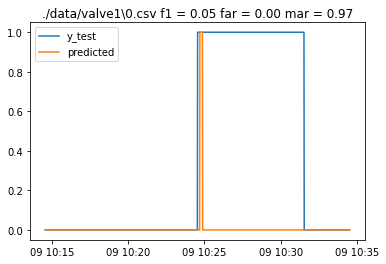

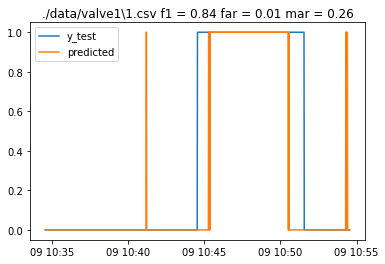

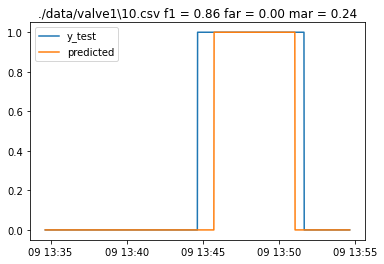

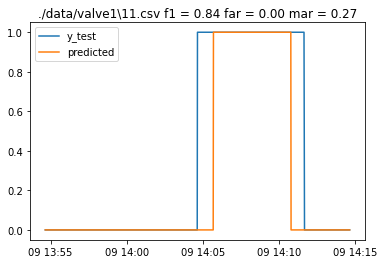

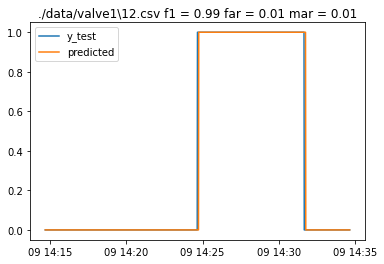

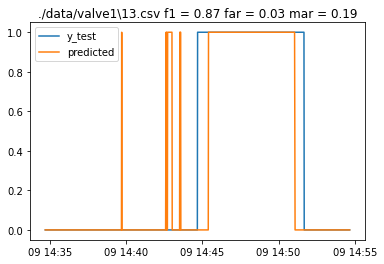

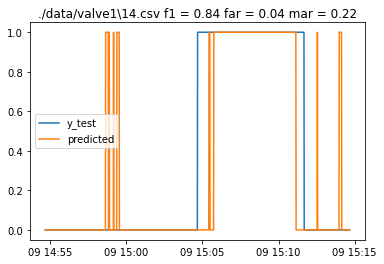

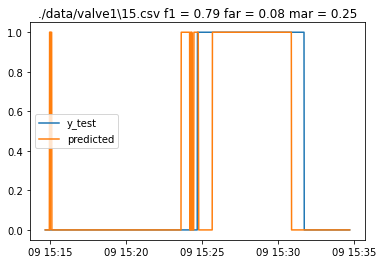

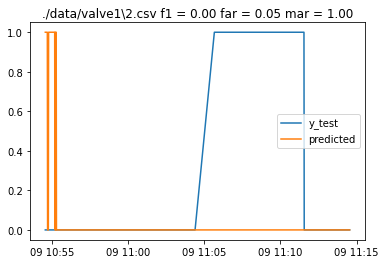

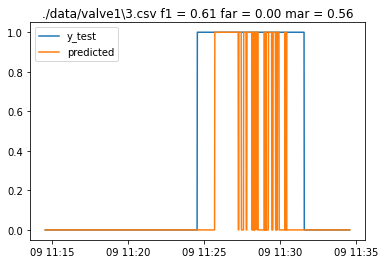

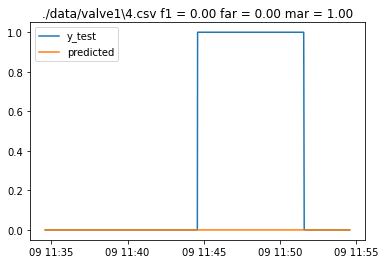

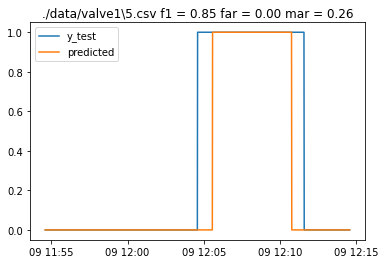

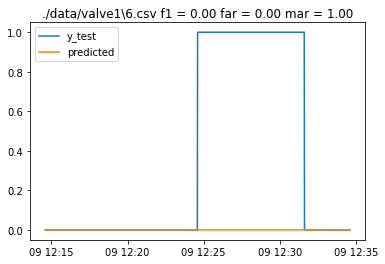

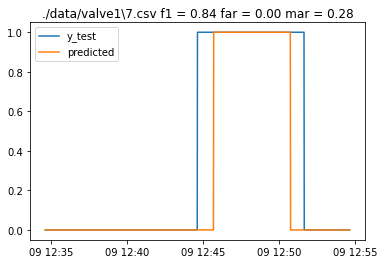

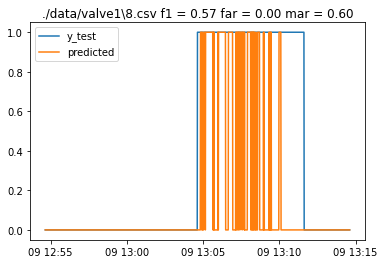

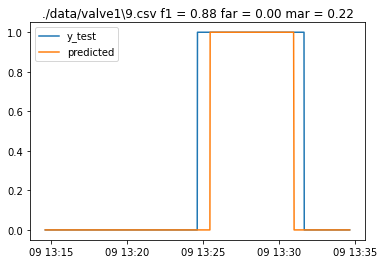

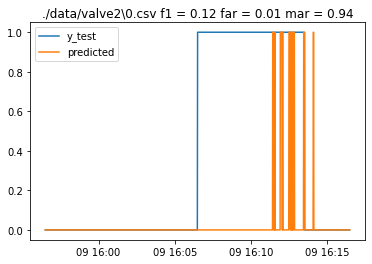

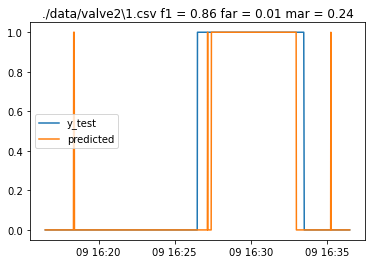

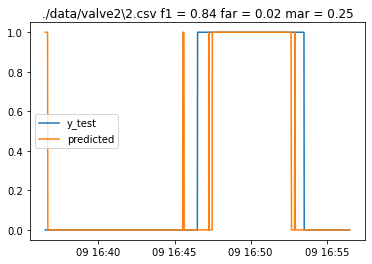

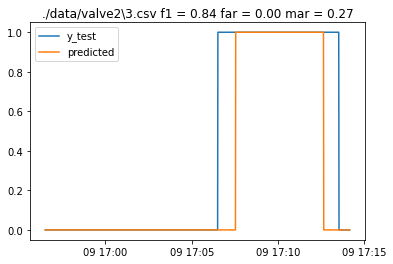

In [27]:

metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [28]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.05 | 0.84 | 0.86 | 0.84 | 0.99 | 0.87 | 0.84 | 0.79 | 0.0 | 0.61 | 0.0 | 0.85 | 0.0 | 0.84 | 0.57 | 0.88 | 0.12 | 0.86 | 0.84 | 0.84
FAR |0.0 | 0.01 | 0.0 | 0.0 | 0.01 | 0.03 | 0.04 | 0.08 | 0.05 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.01 | 0.01 | 0.02 | 0.0
MAR |0.97 | 0.26 | 0.24 | 0.27 | 0.01 | 0.19 | 0.22 | 0.25 | 1.0 | 0.56 | 1.0 | 0.26 | 1.0 | 0.28 | 0.6 | 0.22 | 0.94 | 0.24 | 0.25 | 0.27

metric | valve1 | valve2
--- | --- | ---
F1 |0.7 | 0.72
FAR |0.01 | 0.01
MAR |0.45 | 0.43

### SKAB


In [36]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

from utils.pipeline import Pipeline, Predictor
class Config:
    contamination = 0.01
    
conf = Config

class IForestSKABPredictor:
    def fit(self, df_train):
        self.model = IsolationForest(contamination=conf.contamination, 
                              n_jobs=-1, random_state=seed_value)
        
        self.model.fit(df_train.values)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            prediction_raw = self.model.predict(df.values)
            prediction = pd.Series(self.model.predict(df)*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
            
            predictions[file_name] = prediction
            
        return predictions
    
    

In [37]:
%%time
skab_predictor = IForestSKABPredictor()
skab_predictor.fit(df_train)

CPU times: total: 266 ms
Wall time: 305 ms


In [38]:
%%time
predictions_by_names = skab_predictor.predict(df_by_names)

CPU times: total: 3.39 s
Wall time: 3.55 s


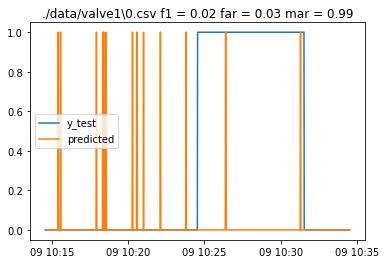

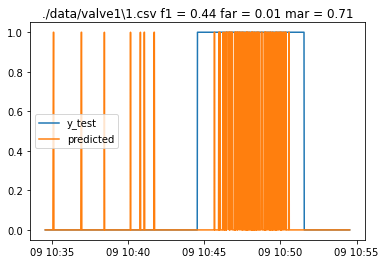

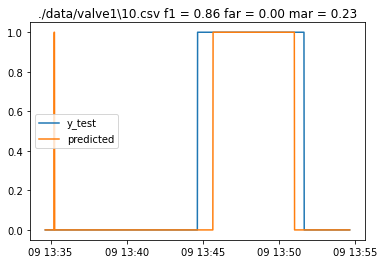

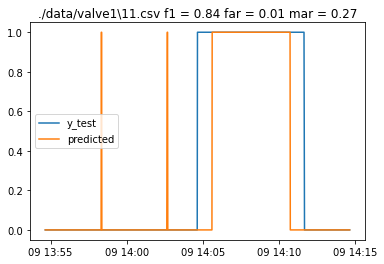

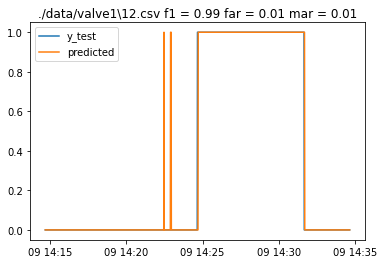

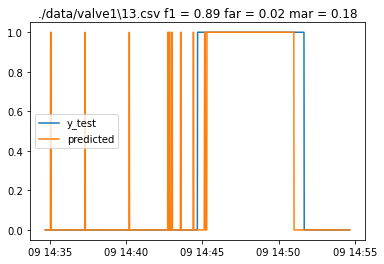

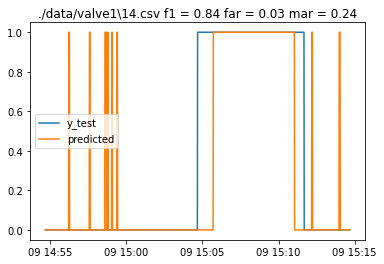

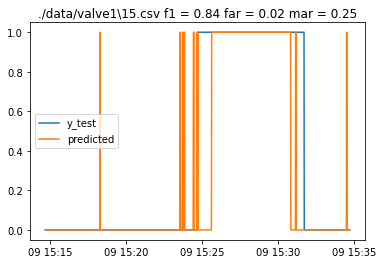

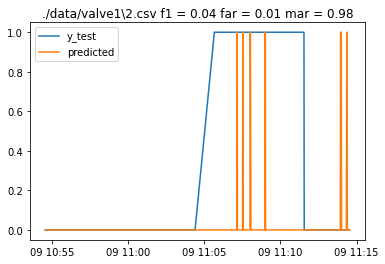

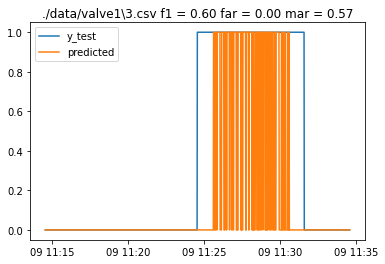

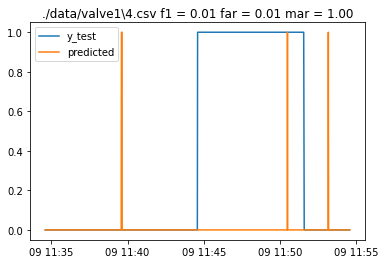

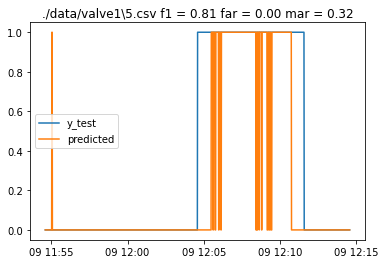

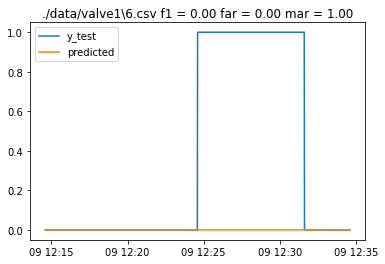

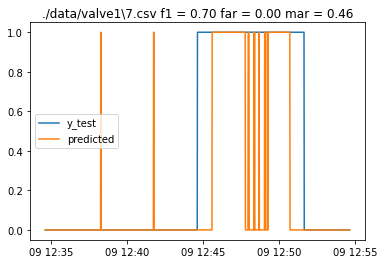

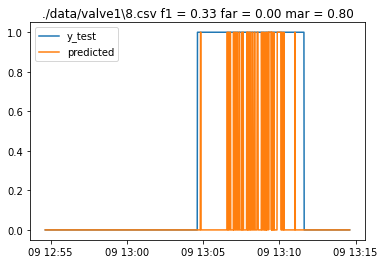

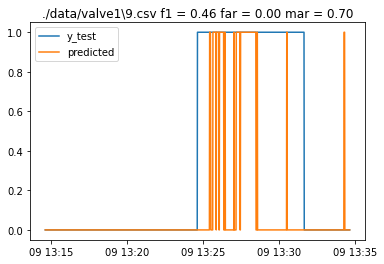

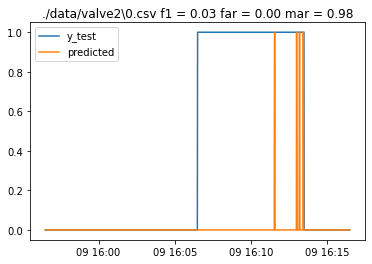

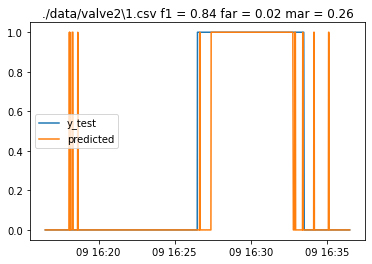

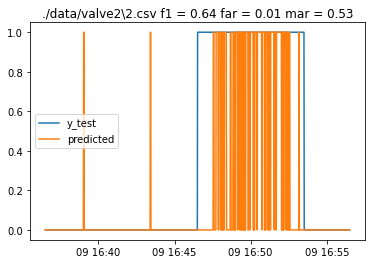

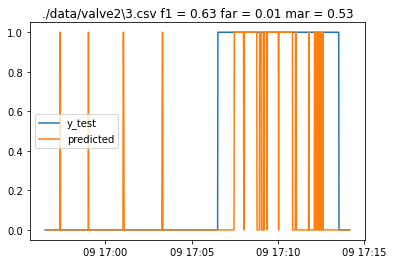

In [39]:

metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [40]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.02 | 0.44 | 0.86 | 0.84 | 0.99 | 0.89 | 0.84 | 0.84 | 0.04 | 0.6 | 0.01 | 0.81 | 0.0 | 0.7 | 0.33 | 0.46 | 0.03 | 0.84 | 0.64 | 0.63
FAR |0.03 | 0.01 | 0.0 | 0.01 | 0.01 | 0.02 | 0.03 | 0.02 | 0.01 | 0.0 | 0.01 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.02 | 0.01 | 0.01
MAR |0.99 | 0.71 | 0.23 | 0.27 | 0.01 | 0.18 | 0.24 | 0.25 | 0.98 | 0.57 | 1.0 | 0.32 | 1.0 | 0.46 | 0.8 | 0.7 | 0.98 | 0.26 | 0.53 | 0.53

metric | valve1 | valve2
--- | --- | ---
F1 |0.63 | 0.58
FAR |0.01 | 0.01
MAR |0.54 | 0.59